<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Kaggle-Challenge/blob/master/NB_Walkie_talkie_week6_DS9_trees__man_and_machine_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, can you talk the talk?

## Walkie Talkie 


Your group will consist of a 4 person team. Your mission simple. Your success, critical. Answer questions relating to content covered in Unit 2 in the allotted time.


Each team member will have a designated role to fulfill.

The writer - Your Job is to record the answers for the group. (You can only write what all members have discussed and agreed to.)

The thinker - Your role is to provide your thoughts for the questions.

The FTE (focus task executive) - Keep the group on task. Personal role: have all questions answered, you will also act as mediator, pushing the group forward if they get stuck.

The artist - For questions answered, your role is to find a picture that make a connection between the question and your answer (you may use multiple pictures to answer).

Please answer each question to the best of your ability as a group. Share your notebook or google doc with your awesome DS9 SL-Guillermo. Remember to put your name and your teammates’ names on there, next to their respective roles. 

###Q1: What is purpose of a pipeline? How does it prepare a model to be fitted? What happens when you fit a model? What are the similarities and differences of One Hot encoding and Ordinal encoding?

###Q2: What is the meaning of the saying “Garbage in, Garbage out”? How do data cleaning, feature engineering, and model preproccessing all play a part?

###Q3: Explain the similarities and differences of the models we have explored so far: Decision tree, Random forest, Logistic regression, Linear regression. Express the pro’s and con’s of each.

###Q4: How can you know that you can be confident in your model? Think of validation techniques as well as accuracy scores, R^2, explanatory and exploratory visuals. You can use Random forest from this week as the backbone of your explanation.



#DIG DEEP HERE, answer these questions in such a way that your answers would make a potential employer impressed with the thoughtfulness of your answers, your mother would be proud of her child, and most importantly, you can be happy with it yourself!




Note: the code below is simply a back drop to faciliate your thinking, and is not required to read to complete this activity. 

In [0]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

## Try Ordinal Encoding. Try a Random Forest Classifier.

In [0]:
import category_encoders as ce
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline


# Split train into train & val
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['status_group'], random_state=42)


def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""
    
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    # Also create a "missing indicator" column, because the fact that
    # values are missing may be a predictive signal.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 
                       'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()
            
    # Drop duplicate columns
    duplicates = ['quantity_group', 'payment_type']
    X = X.drop(columns=duplicates)
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_MISSING'] = X['years'].isnull()
    
    # return the wrangled dataframe
    return X

train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

In [0]:
# Arrange data into X features matrix and y target vector
target = 'status_group'
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.8135521885521886


## Get and plot your feature importances

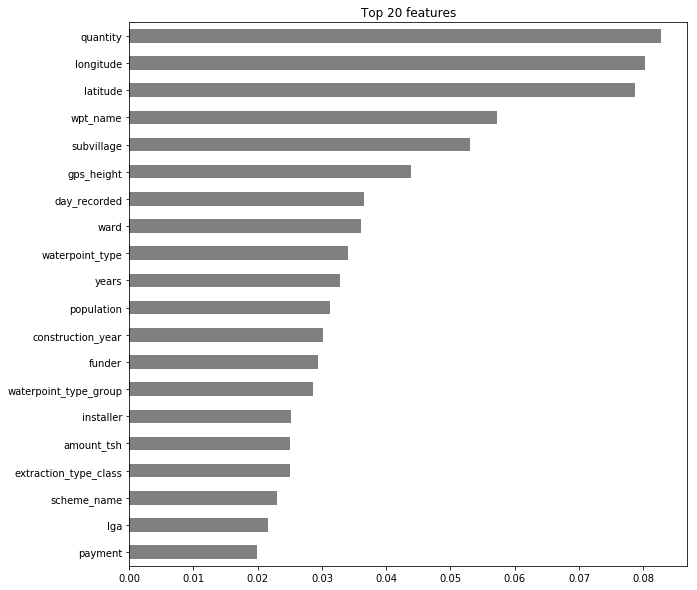

In [0]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

## Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/)

In [0]:
for min_samples_leaf in [1, 10, 100, 1000]:
    for smoothing in [1, 10, 100, 1000]:
        print(f'TargetEncoder(min_samples_leaf={min_samples_leaf}, smoothing={smoothing})')
        encoder = ce.TargetEncoder(min_samples_leaf=min_samples_leaf, smoothing=smoothing)
        X_train_encoded = encoder.fit_transform(X_train, y_train=='functional')
        X_val_encoded = encoder.transform(X_val, y_val=='functional')

        pipeline = make_pipeline(
            SimpleImputer(strategy='median'), 
            RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        )

        pipeline.fit(X_train_encoded, y_train)
        print('Validation Accuracy', pipeline.score(X_val_encoded, y_val), '\n')

TargetEncoder(min_samples_leaf=1, smoothing=1)
Validation Accuracy 0.7839225589225589 

TargetEncoder(min_samples_leaf=1, smoothing=10)
Validation Accuracy 0.7853535353535354 

TargetEncoder(min_samples_leaf=1, smoothing=100)
Validation Accuracy 0.782070707070707 

TargetEncoder(min_samples_leaf=1, smoothing=1000)
Validation Accuracy 0.7829124579124579 

TargetEncoder(min_samples_leaf=10, smoothing=1)
Validation Accuracy 0.793939393939394 

TargetEncoder(min_samples_leaf=10, smoothing=10)
Validation Accuracy 0.7888047138047138 

TargetEncoder(min_samples_leaf=10, smoothing=100)
Validation Accuracy 0.7840909090909091 

TargetEncoder(min_samples_leaf=10, smoothing=1000)
Validation Accuracy 0.7842592592592592 

TargetEncoder(min_samples_leaf=100, smoothing=1)
Validation Accuracy 0.8122895622895623 

TargetEncoder(min_samples_leaf=100, smoothing=10)
Validation Accuracy 0.7934343434343434 

TargetEncoder(min_samples_leaf=100, smoothing=100)
Validation Accuracy 0.7838383838383839 

TargetEnc

/usr/local/lib/python3.6/dist-packages/category_encoders/target_encoder.py:170: RuntimeWarning: overflow encountered in exp
  smoove = 1 / (1 + np.exp(-(stats['count'] - self.min_samples_leaf) / self.smoothing))


Validation Accuracy 0.8085858585858586 

TargetEncoder(min_samples_leaf=1000, smoothing=10)
Validation Accuracy 0.8098484848484848 

TargetEncoder(min_samples_leaf=1000, smoothing=100)
Validation Accuracy 0.7884680134680134 

TargetEncoder(min_samples_leaf=1000, smoothing=1000)
Validation Accuracy 0.7835858585858586 

